## 0 for residue without contacts and 1 for residue with contacts

In [ ]:
import pandas as pd
import os

base_directory = 'DTW/11-WT'
chain_folders = ['contacts_chain_A', 'contacts_chain_B']

# Iterate over each chain folder
for chain in chain_folders:
    chain_directory = os.path.join(base_directory, chain)
    
    for filename in os.listdir(chain_directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(chain_directory, filename)
            df = pd.read_csv(filepath)
            residue_columns = [col for col in df.columns if not col.startswith('Frame.')]
            for column in residue_columns:
                df[column] = df[column].map(lambda x: 1 if x != 0 else 0)
            df.to_csv(filepath, index=False)


## concatenating the chain A and B of the WT 

In [ ]:
import os
import pandas as pd
import re

# Specify the folder paths
folder_path_A = 'DTW/11-WT/contacts_chain_A'
folder_path_B = 'DTW/11-WT/contacts_chain_B'

# Helper function to extract the number from the file name
def extract_number(file_name):
    match = re.search(r'(\d+)', file_name)
    return match.group(1) if match else None

# Get lists of CSV files from both folders
files_A = [f for f in os.listdir(folder_path_A) if f.endswith('.csv')]
files_B = [f for f in os.listdir(folder_path_B) if f.endswith('.csv')]

# Create a dictionary to group files by their extracted number
file_groups = {}

# Group files from folder A
for file_name in files_A:
    number = extract_number(file_name)
    if number:
        file_path = os.path.join(folder_path_A, file_name)
        file_groups.setdefault(number, {}).update({'A': file_path})

# Group files from folder B
for file_name in files_B:
    number = extract_number(file_name)
    if number:
        file_path = os.path.join(folder_path_B, file_name)
        file_groups.setdefault(number, {}).update({'B': file_path})

# Loop through each group and concatenate matching files
for number, paths in file_groups.items():
    if 'A' in paths and 'B' in paths:
        # Read the CSV files
        df_A = pd.read_csv(paths['A'])
        df_B = pd.read_csv(paths['B'])
        
        # Concatenate DataFrames horizontally (along columns)
        concatenated_df = pd.concat([df_A, df_B], axis=1)
        
        # Save or process the concatenated DataFrame
        output_path = f'/DTW/data_cleaned/contacts_chain_AB_{number}.csv'
        concatenated_df.to_csv(output_path, index=False)
        



## calculation and normalization of the distance matrix

In [ ]:
import os
import pandas as pd
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Function to load and select only the contact columns
def select_contact_columns(file_path):
    df = pd.read_csv(file_path)
    # Select only columns that start with "# Contacts"
    contact_columns = [col for col in df.columns if col.startswith('# Contacts')]
    return df[contact_columns]
/Users/aliakbarhasnain/Desktop/unsupervised_learning/notebooks/dtw_calculation_WT.ipynb
# Function to calculate DTW distance and alignment length
def calculate_dtw_distance(data1, data2):
    contact_array1 = data1.to_numpy()
    contact_array2 = data2.to_numpy()
    # Convert each array into a list of tuples for multi-dimensional DTW
    data1_tuples = [tuple(row) for row in contact_array1]
    data2_tuples = [tuple(row) for row in contact_array2]
    # Compute the DTW distance and the alignment path
    distance, path = fastdtw(data1_tuples, data2_tuples, dist=euclidean)
    alignment_length = len(path)  # Length of the alignment
    return distance, alignment_length

# Function to calculate and normalize pairwise distances between all CSVs in a folder
def calculate_pairwise_distances(folder_path):
    # Get all CSV file paths in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    # Load the contact data from each CSV file
    group_data = [select_contact_columns(os.path.join(folder_path, file)) for file in csv_files]
    
    # Initialize a distance matrix (with zeros initially)
    num_files = len(csv_files)
    distance_matrix = pd.DataFrame(0.0, index=csv_files, columns=csv_files)
    
    # Calculate distances for each pair of CSV files
    for i in range(num_files):
        for j in range(i, num_files):
            distance, alignment_length = calculate_dtw_distance(group_data[i], group_data[j])
            # Normalize the distance by the alignment length
            normalized_distance = distance / alignment_length
            # Store the normalized distance in both [i, j] and [j, i] positions
            distance_matrix.iloc[i, j] = normalized_distance
            distance_matrix.iloc[j, i] = normalized_distance
    
    return distance_matrix

# Define the folder containing your CSV files
folder_path = '/DTW/data_cleaned'

# Calculate the normalized pairwise distances
distance_matrix = calculate_pairwise_distances(folder_path)

# Save the result to a CSV file
distance_matrix.to_csv('/DTW/normalized_output.csv')




## K-Means clustering with validation

In [15]:
def run_kmeans_mds_with_metrics(distance_matrix_file="/DTW/normalized_output.csv",
                                labels_file="/DTW/labels.csv",
                                n_clusters=7):
    import pandas as pd
    import numpy as np
    import plotly.express as px
    from sklearn.cluster import KMeans
    from sklearn.manifold import MDS
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import silhouette_score, davies_bouldin_score

    #Load data
    distance_matrix = pd.read_csv(distance_matrix_file, index_col=0)
    labels = pd.read_csv(labels_file, header=None)

    trajectory_names = distance_matrix.index.tolist()
    group_labels = labels[1].tolist()

    if len(trajectory_names) != len(group_labels):
        raise ValueError("Distance matrix and labels must have the same length.")

    # Preprocess distance matrix
    distance_matrix = distance_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)
    np.fill_diagonal(distance_matrix.values, 0)
    distance_matrix = (distance_matrix + distance_matrix.T) / 2

    # Normalize
    scaler = StandardScaler()
    normalized_distance_matrix = scaler.fit_transform(distance_matrix.values)
    normalized_distance_matrix = (normalized_distance_matrix + normalized_distance_matrix.T) / 2

    # MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    mds_transformed = mds.fit_transform(normalized_distance_matrix)

    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')
    kmeans_labels = kmeans.fit_predict(mds_transformed)

    # Calculate metrics
    silhouette_avg = silhouette_score(mds_transformed, kmeans_labels)
    db_index = davies_bouldin_score(mds_transformed, kmeans_labels)

    # DataFrame for plotting
    plot_df = pd.DataFrame({
        "MDS1": mds_transformed[:, 0],
        "MDS2": mds_transformed[:, 1],
        "Cluster": kmeans_labels,
        "Trajectory": trajectory_names,
        "Group": group_labels
    })

    # Sort by group
    plot_df["Group"] = pd.Categorical(plot_df["Group"], categories=sorted(set(group_labels)), ordered=True)
    plot_df = plot_df.sort_values("Group")

    y_max = max(abs(plot_df["MDS2"].min()), abs(plot_df["MDS2"].max())) + 0.1

    # Plot
    fig = px.scatter(
        plot_df, x="MDS1", y="MDS2", color="Group",
        hover_data={"MDS1": False, "MDS2": False, "Trajectory": True, "Group": True},
        title="K-Means Clustering",
        color_discrete_sequence=px.colors.qualitative.Bold
    )

    fig.update_layout(
        legend=dict(
            title="Groups",
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.02
        ),
        autosize=False,
        width=1000,
        height=800,
        plot_bgcolor="white",
        paper_bgcolor="white",
        xaxis=dict(showgrid=True, gridcolor="lightgrey", zeroline=False),
        yaxis=dict(showgrid=True, gridcolor="lightgrey", zeroline=False, range=[-y_max, y_max]),
        margin=dict(l=50, r=50, b=50, t=50, pad=10),
        title=dict(text="K-Means Clustering", x=0.5, xanchor="center"),
        shapes=[dict(type="rect", xref="paper", yref="paper",
                     x0=0, y0=0, x1=1, y1=1,
                     line=dict(color="black", width=2))]
    )

    return fig, {"Silhouette Score": silhouette_avg, "Davies-Bouldin Index": db_index}

fig, metrics = run_kmeans_mds_with_metrics("/Users/aliakbarhasnain/Desktop/unsupervised_learning/DTW/normalized_output.csv", "/Users/aliakbarhasnain/Desktop/unsupervised_learning/DTW/labels.csv", n_clusters=7)

fig.show()
print(metrics)


{'Silhouette Score': 0.334029708567554, 'Davies-Bouldin Index': 0.8321070677793461}


Performing clustering with linkage method: complete


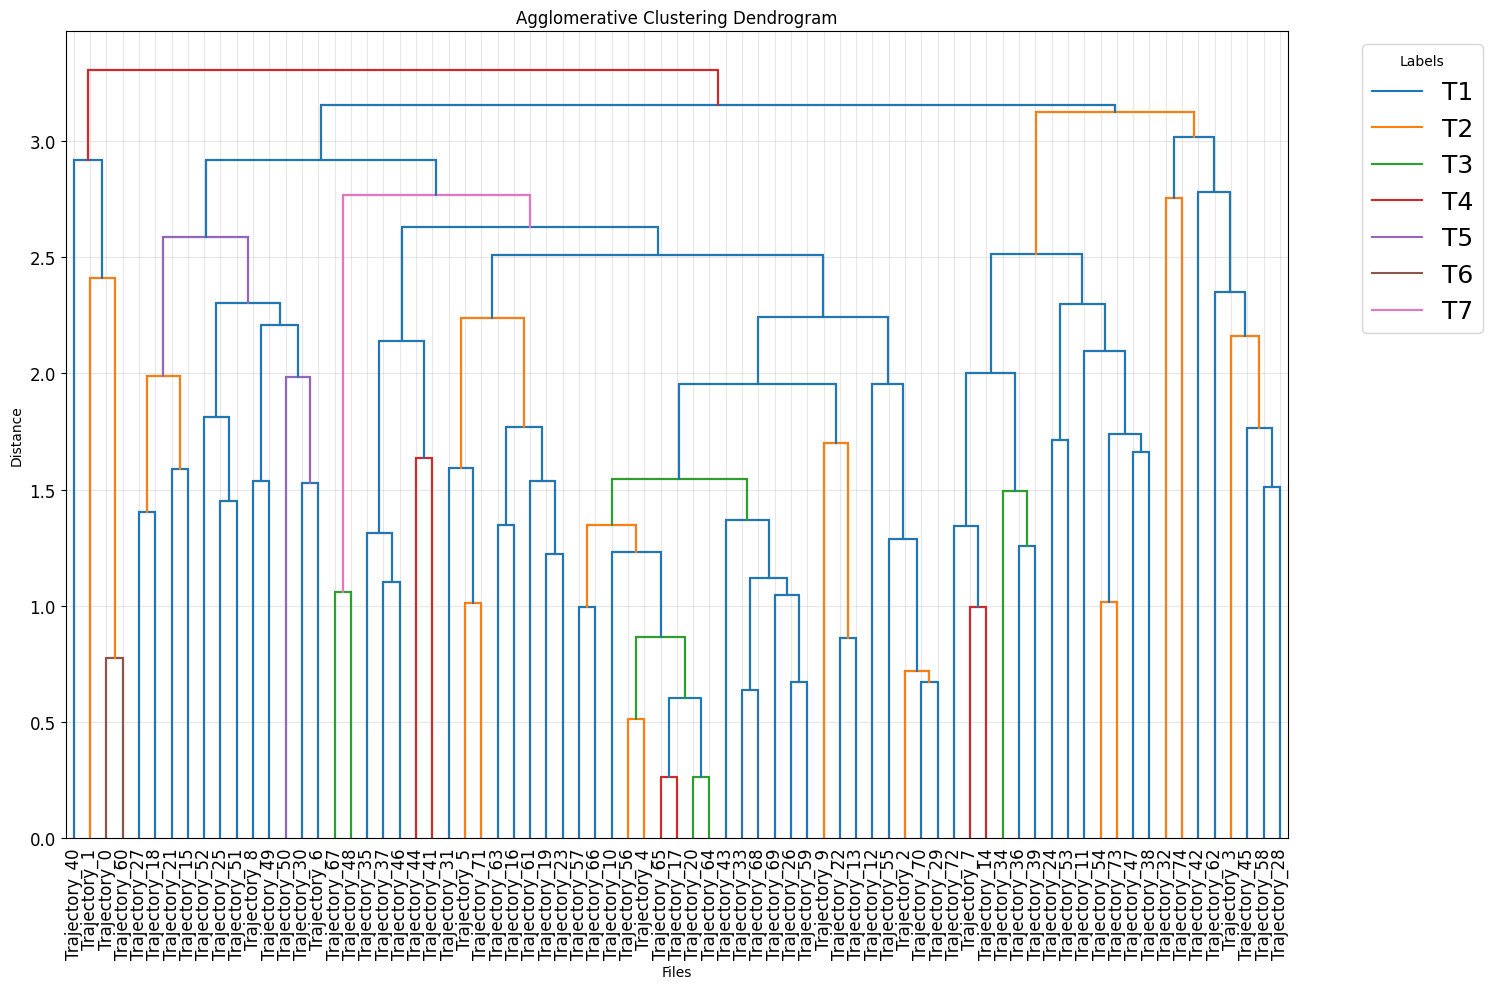

Silhouette Score: 0.1387
Davies-Bouldin Index: 1.5699


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

# Config
distance_matrix_file = "/DTW/normalized_output.csv"
labels_file = "/DTW/labels.csv"
linkage_method = 'complete'

# Load Data
distance_matrix = pd.read_csv(distance_matrix_file, index_col=0)
labels_df = pd.read_csv(labels_file, header=None)
tick_labels = [f"Trajectory_{name.replace('.csv', '').split('_')[-1]}" for name in distance_matrix.index]
color_labels = labels_df[1].tolist()

assert distance_matrix.shape[0] == distance_matrix.shape[1] == len(color_labels), \
    "Distance matrix and labels must have the same dimensions."

# Preprocess Matrix 
distance_matrix = distance_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)
np.fill_diagonal(distance_matrix.values, 0)

# Clustering 
n_clusters = len(set(color_labels))
print(f"Performing clustering with linkage method: {linkage_method}")
clustering_model = AgglomerativeClustering(
    n_clusters=n_clusters, 
    metric="precomputed", 
    linkage=linkage_method
)
cluster_assignments = clustering_model.fit_predict(distance_matrix.values)

# Label to Color Mapping
unique_labels = sorted(set(color_labels))
label_to_color = {label: idx for idx, label in enumerate(unique_labels)}
cmap = ListedColormap(plt.cm.tab10.colors[:len(unique_labels)])

# Plotting Function
def plot_colored_dendrogram(linkage_matrix, labels, color_labels, threshold=0.0):
    plt.figure(figsize=(15, 10))
    dendro = dendrogram(
        linkage_matrix,
        labels=labels,
        leaf_rotation=90,
        leaf_font_size=10,
        above_threshold_color="black",
        color_threshold=threshold
    )

    ax = plt.gca()
    icoords = np.array(dendro['icoord'])
    dcoords = np.array(dendro['dcoord'])
    xlbls = ax.get_xmajorticklabels()

    # Color each linkage line based on leaf label
    colors = [label_to_color[color_labels[labels.index(lbl.get_text())]] for lbl in xlbls]
    for xs, ys, c in zip(icoords, dcoords, colors):
        ax.plot(xs, ys, color=cmap(c))

    # Add legend
    for idx, label in enumerate(unique_labels):
        plt.plot([], [], label=label, color=cmap(idx))
    plt.legend(title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18)

    plt.title("Agglomerative Clustering Dendrogram")
    plt.xlabel("Files")
    plt.ylabel("Distance")
    plt.xticks(rotation=90)
    plt.yticks(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.tight_layout()
    plt.show()

# Linkage Matrix & Plot 
linkage_matrix = linkage(squareform(distance_matrix.values), method=linkage_method)
threshold = 0.2 * max(linkage_matrix[:, 2])
plot_colored_dendrogram(linkage_matrix, tick_labels, color_labels, threshold)

from sklearn.metrics import silhouette_score, davies_bouldin_score

# Compute Silhouette Score
silhouette_avg = silhouette_score(distance_matrix, cluster_assignments, metric='precomputed')
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Compute Davies-Bouldin Index
db_index = davies_bouldin_score(distance_matrix, cluster_assignments)
print(f"Davies-Bouldin Index: {db_index:.4f}")



## evaluation of the calculated distances

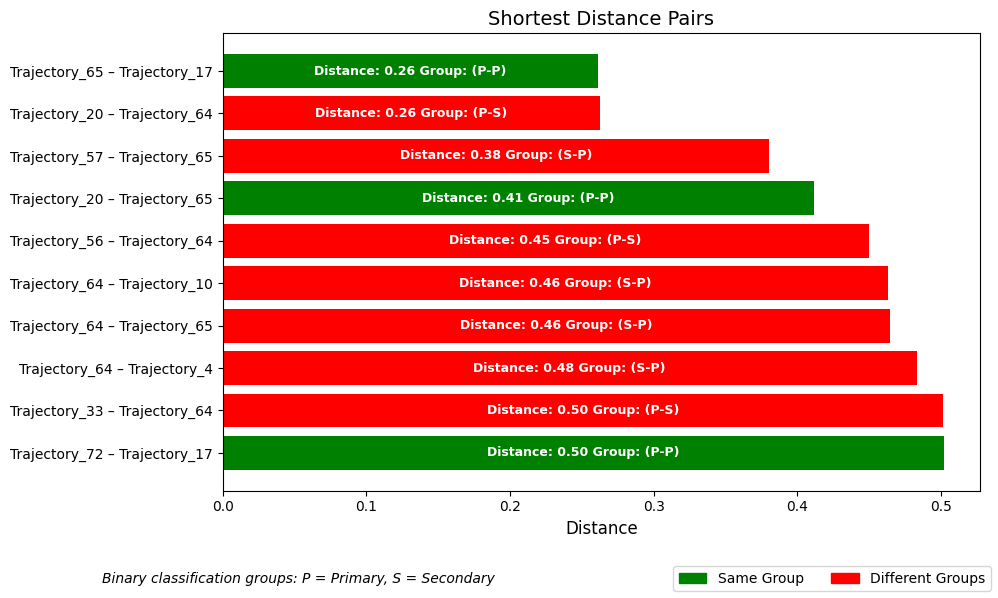

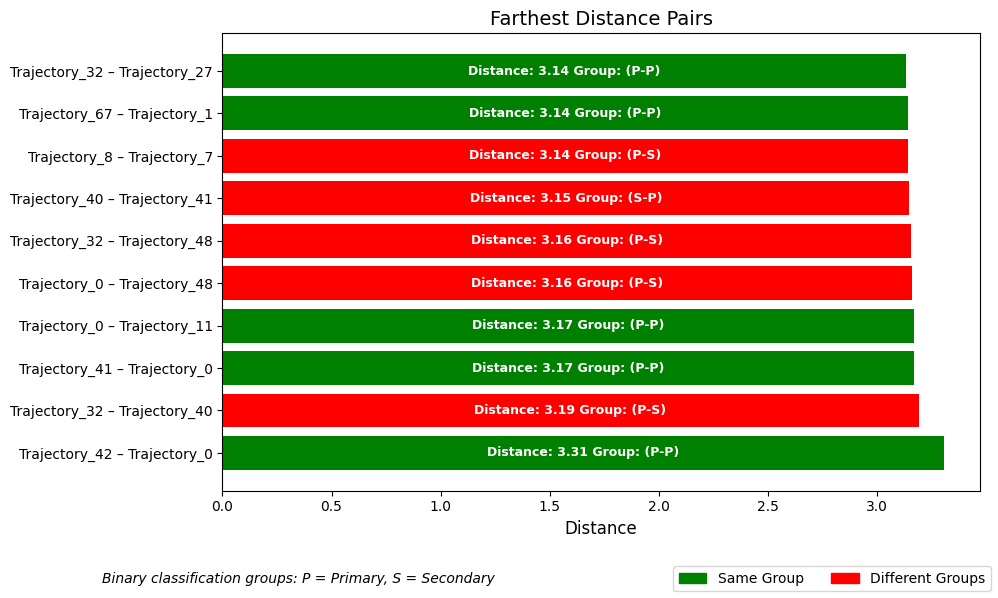

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


#Load and preprocess data 
distance_matrix = pd.read_csv("/DTW/normalized_output.csv", index_col=0)
labels_df = pd.read_csv("/DTW/labels.csv", header=None)

# Clean trajectory names like "contacts_chain_AB_65" -> "Trajectory_65"
trajectory_names = [f"Trajectory_{name.replace('.csv', '').split('_')[-1]}" for name in distance_matrix.index]


# Extract the last column of labels and map to short codes
raw_groups = labels_df.iloc[:, -1].astype(str)
group_labels = raw_groups.replace({
    'primary-secondary': 'P-S',
    'Primary': 'P',
    'Secondary': 'S'
}).tolist()

# Preprocess the distance matrix
distance_matrix = distance_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)
np.fill_diagonal(distance_matrix.values, 0)
distance_matrix = (distance_matrix + distance_matrix.T) / 2  # Ensure symmetry

# Get upper triangle indices
triu_indices = np.triu_indices(len(distance_matrix), k=1)
pairwise_distances = distance_matrix.values[triu_indices]

# Sort distances and get top 10 smallest and largest
sorted_indices = np.argsort(pairwise_distances)
shortest_indices = sorted_indices[:10]
farthest_indices = sorted_indices[-10:]

# Helper function to prepare pairs
def extract_pairs(indices):
    pairs = []
    for idx in indices:
        i, j = triu_indices[0][idx], triu_indices[1][idx]
        traj_i = trajectory_names[i]
        traj_j = trajectory_names[j]
        group_i = group_labels[i]
        group_j = group_labels[j]
        dist = distance_matrix.values[i, j]
        label = f"{traj_i} – {traj_j}"
        pairs.append((label, group_i, group_j, dist))
    return pairs

shortest = extract_pairs(shortest_indices)
farthest = extract_pairs(farthest_indices)

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_distance_panel(data, title, filename):
    labels = []
    distances = []
    colors = []

    for label, g1, g2, dist in data:
        labels.append(label)
        distances.append(dist)
        same_group = (g1 == g2)
        colors.append("green" if same_group else "red")

    fig, ax = plt.subplots(figsize=(10, 6))  # Individual figure
    bars = ax.barh(labels, distances, color=colors)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Distance", fontsize=12)
    ax.invert_yaxis()

    # Write text inside the bar
    for bar, (_, g1, g2, dist) in zip(bars, data):
        x_pos = bar.get_width() / 2
        y_pos = bar.get_y() + bar.get_height() / 2
        ax.text(x_pos, y_pos, f"Distance: {dist:.2f} Group: ({g1}-{g2})", va='center', ha='center', fontsize=9, color='white', weight='bold')

    # Legend
    same_patch = mpatches.Patch(color='green', label='Same Group')
    diff_patch = mpatches.Patch(color='red', label='Different Groups')
    fig.legend(handles=[same_patch, diff_patch], loc='lower right', ncol=2, fontsize=10)

    # Leave room for bottom text
    plt.tight_layout(rect=[0, 0.07, 1, 1])

    # Explanatory text
    fig.text(
        0.5, 0.02,  # centered below the plot
        "Binary classification groups: P = Primary, S = Secondary",
        ha='right',
        fontsize=10,
        style='italic'
    )

    # Save and show
    plt.savefig(filename, dpi=300)
    plt.show()

# Call the function for both plots
plot_distance_panel(shortest, "Shortest Distance Pairs", "shortest_distance_plot.png")
plot_distance_panel(farthest, "Farthest Distance Pairs", "farthest_distance_plot.png")
